## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit  #разбиение для временных рядов
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error

import xgboost
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from xgboost import DMatrix
from lightgbm import LGBMRegressor
from lightgbm import Dataset
import lightgbm
from sklearn.dummy import DummyRegressor

In [2]:
df = pd.read_csv('C:/отчеты/Яндекс/проекты/Временные ряды/taxi.csv',  index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

In [4]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df = df.resample('1H').sum()

In [6]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

## 2.1 Скользящее среднее 

In [7]:
df_info = df.copy(deep = True)

In [8]:
df_info['rolling_mean'] = df.rolling(110).mean()

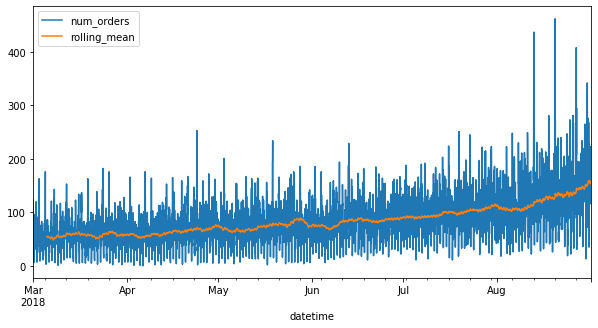

In [9]:
df_info.plot(figsize = (10,5))

## 2.2 Тренды и сезонность

In [10]:
decomposed = seasonal_decompose(df)

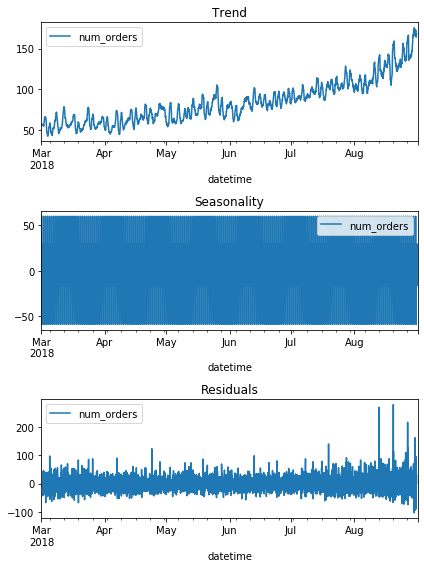

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Общий тренд - рост количества заказов такси с марта по август.        
График сезонности выглядит странным, похоже, что циклично-повторяющихся закономерностей нет 

Text(0.5, 1.0, 'Seasonality')

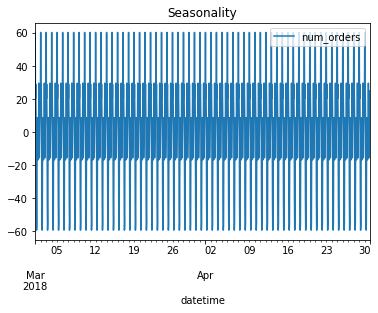

In [12]:
decomposed.seasonal['2018-03' : '2018-04'].plot(ax=plt.gca())
plt.title('Seasonality')

Сокаращу временной интервал до недели

Text(0.5, 1.0, 'Seasonality')

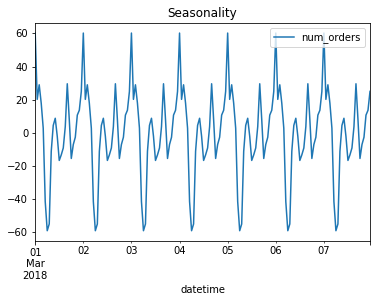

In [13]:
decomposed.seasonal['2018-03-01' : '2018-03-07'].plot(ax=plt.gca())
plt.title('Seasonality')

Видно, что пик числа заказов такси приходится на конец дня (11-12 вечера). Но это качается только лишь первой недели марта. Да и амплетуда для каждого дня одинакова, что тоже странно. Посмотрю на сезоннность по дням каждой второй недели каждого месяца

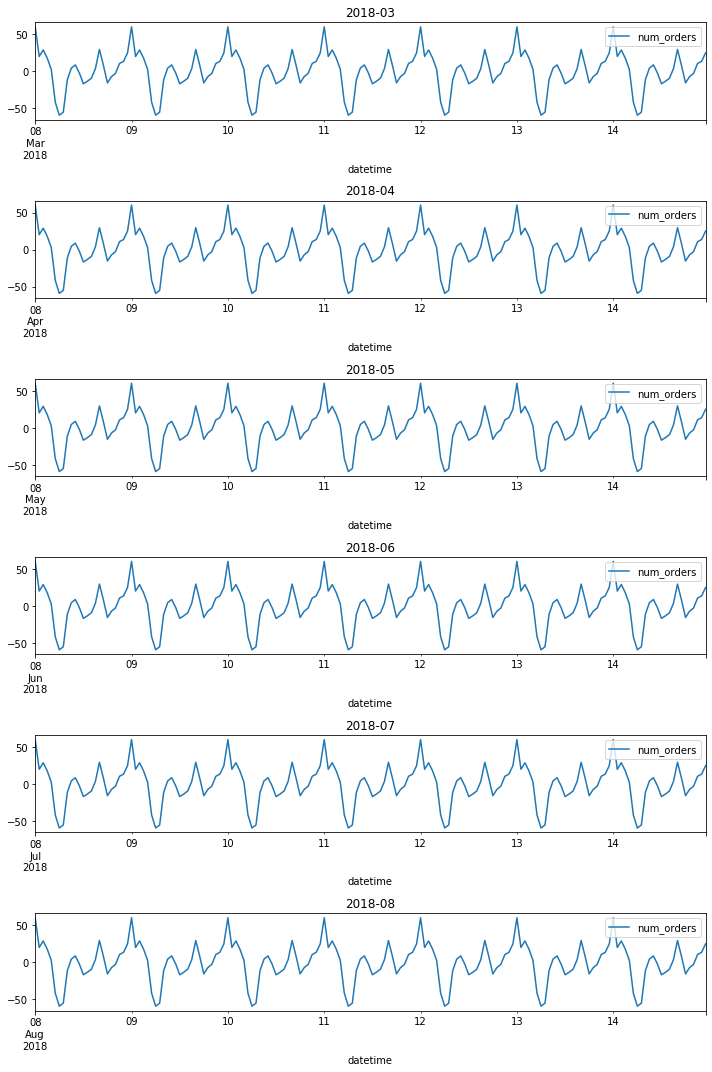

In [14]:
plt.figure(figsize=(10, 15))
for i in range(1,7):   # грфиков должно быть 6
    plt.subplot(6,1,i)
    decomposed.seasonal['2018-0' + str(i+2) + '-08 00:00:00' : '2018-0' + str(i+2) +'-14 23:00:00'].plot(ax=plt.gca())
    plt.title('2018-0' + str(i+2))
    plt.tight_layout()
    

Судя по графикам, распределение заказов по часам одинаковое для каждой второй недели каждого месяца. Каждый день наблюдаются 3 пика: между 11 вечера и часом ночи, примерно в 4 часа дня и примерно в 8 вечера. 

# 3. Обучение

In [15]:
#Функция для уменьшения объема хранения в памяти:
def reduce_mem_usage(df, verbose=True, not_used_cols = []):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        
        # Комментарий ревьюера:
        #   не очень удачное название массива, из-за которого
        #   в коде появилось двойное отрицание (not in not_...) 
        #   и читать стало сложно :) К тому же, ему нигде не присвается 
        #   отличное от дефолтного значение - так ли он нужен? 
        
        if col not in not_used_cols:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Память хранения уменьшена с {:5.2f} Mb до {:5.2f} Mb, итого ({:.1f}% уменьшения)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [18]:
make_features(df, 98, 110)

In [19]:
df.head(10)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def lgb_RMSE(preds, dataset):
    labels = dataset.get_label()
    score = mean_squared_error(labels, preds)**0.5
    return ('rmse', score, False)

In [21]:
# Напишу функцию зависимости RMSE модели LGBM от количества отстающих признаков 

def lag_features_comarison(data, max_lag_min, max_lag_max, rolling_mean_size, name_of_target_column, model_params):
    
    RMSE_stat = []
    max_lag_number_stat = []
    #cоздание фич
    for max_lag_number in range(max_lag_min, max_lag_max + 1):
        data['year'] = data.index.year
        data['month'] = data.index.month
        data['day'] = data.index.day
        data['dayofweek'] = data.index.dayofweek
        data['hour'] = data.index.hour
        
        
        for lag in range(1, max_lag_number + 1):
            data['lag_{}'.format(lag)] = data[name_of_target_column].shift(lag)

        data['rolling_mean'] = data[name_of_target_column].shift().rolling(rolling_mean_size).mean()
    #разбиение 
        train, test = train_test_split(data, shuffle=False, test_size=0.1)
        train = train.dropna()
        train_features = train.drop([name_of_target_column], axis = 1)
        train_target = train[name_of_target_column]
        test_features = test.drop([name_of_target_column], axis = 1)
        test_target = test[name_of_target_column]
    
    #обучение LGBM
        lgb_dataset = Dataset(data = train_features, label = train_target)
        lgbm_model = lightgbm.train(params = model_params,
                                    train_set = lgb_dataset,
                                    num_boost_round = 1000,
                                    feval = lgb_RMSE
                                    )
    #тестирование
        lgbm_predict = lgbm_model.predict(test_features)
        lgbm_test_score = RMSE(test_target, lgbm_predict)
        
        RMSE_stat.append(lgbm_test_score)
        max_lag_number_stat.append(max_lag_number)
        
    line_graph = plt.plot(max_lag_number_stat, RMSE_stat)
    print('Лучшие значения :')
    print(min(RMSE_stat))
    print(RMSE_stat.index(min(RMSE_stat)))
    return line_graph, 

In [22]:
params_for_func = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 1000,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

C:\programs\programming\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\programs\programming\anaconda\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\programs\programming\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\programs\programming\anaconda\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\programs\programming\anaconda\l

Лучшие значения :
37.92804639569267
98
Wall time: 5min 13s


([<matplotlib.lines.Line2D at 0x63853c4048>],)

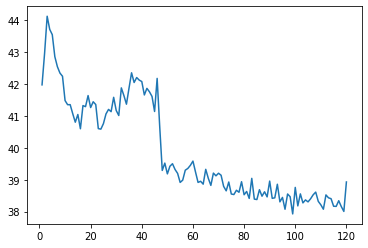

In [360]:
%%time
lag_features_comarison(df, 1, 120, 110, 'num_orders', params_for_func)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 105 entries, num_orders to rolling_mean
dtypes: float64(99), int64(6)
memory usage: 3.7 MB


In [24]:
df = reduce_mem_usage(df)

Память хранения уменьшена с  3.73 Mb до  1.06 Mb, итого (71.6% уменьшения)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 105 entries, num_orders to rolling_mean
dtypes: float16(99), int16(2), int8(4)
memory usage: 1.1 MB


In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis = 1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis = 1)
test_target = test['num_orders']

### Масштабирование

слегка ухудшило результаты

In [317]:
#scaler = StandardScaler()  
#scaler.fit(train_features)

#train_features = scaler.transform(train_features)
#test_features = scaler.transform(test_features)

## 3.1 LightGBM

In [400]:
def lgb_RMSE(preds, dataset):
    labels = dataset.get_label()
    score = mean_squared_error(labels, preds)**0.5
    return ('rmse', score, False)

In [401]:
lgb_model = LGBMRegressor()

In [402]:
lgb_params = {'learning_rate': [0.05, 0.1, 0.15],
               'max_depth': [-1],
               'num_leaves': [1000, 2000],
               'n_jobs':[-1]
             }

In [403]:
scorer_lgb = make_scorer(RMSE, greater_is_better=False)

In [404]:
# лобавлю кроссвалидатор для временных рядов
tscv = TimeSeriesSplit(n_splits=3)

In [405]:
grid_obj_lgb = GridSearchCV(lgb_model, lgb_params, scoring = scorer_lgb, cv = tscv)

In [406]:
%%time
grid_obj_lgb = grid_obj_lgb.fit(train_features, train_target)

Wall time: 33 s


In [407]:
lgb_model = grid_obj_lgb.best_estimator_

In [408]:
lgb_optimal_params = lgb_model.get_params()

In [409]:
lgb_optimal_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 1000,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [410]:
lgb_dataset = Dataset(data = train_features, label = train_target)

In [411]:
%%time
lgbm_model = lightgbm.train(params = lgb_optimal_params,
                            train_set = lgb_dataset,
                            num_boost_round = 2000,
                            feval = lgb_RMSE
                            )

C:\programs\programming\anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\programs\programming\anaconda\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Wall time: 3.36 s


аааа :D Теперь понятно, спасибо :)

## 3.2 XGBoost

In [413]:
def xgb_RMSE(preds, DMatrix):
    labels = DMatrix.get_label()
    score = mean_squared_error(labels, preds)**0.5
    return ('rmse', score, False)

In [414]:
xgb_model =  XGBRegressor(eval_metric = 'rmse')

In [415]:
param_gs_xgb = {'eta': [0.05, 0.1, 0.15],
              'max_depth': [6], 
                'max_leaves': [1000, 2000],
               'n_jobs':[-1],
               }

In [29]:
tscv = TimeSeriesSplit(n_splits=3)

In [417]:
scorer_xgb = make_scorer(RMSE, greater_is_better=False)

In [418]:
grid_obj_xgb = GridSearchCV(xgb_model, param_gs_xgb, cv = tscv, scoring = scorer_xgb)

In [419]:
%%time
grid_obj_xgb = grid_obj_xgb.fit(train_features, train_target)


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:42:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\programs\programming\anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:42:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 16.9 s


In [420]:
# определить для reg_one лучшие гиперпараметры
xgb_model = grid_obj_xgb.best_estimator_

In [421]:
xgb_best_params = xgb_model.get_params()

In [422]:
xgb_best_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'eval_metric': 'rmse',
 'eta': 0.05,
 'max_leaves': 1000}

In [423]:
xgb_data = xgboost.DMatrix(data = train_features, label=train_target)

In [424]:
izmenil_slovar_rukami = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': 0,  ################## было None
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0, ##################  было None
 'silent': False, ################### было None
 'subsample': 1,
 'verbosity': 1,
 'eval_metric': 'rmse',
 'eta': 0.05,
 'max_leaves': 1000}

In [425]:
%%time
xgb_model = xgboost.train(params = izmenil_slovar_rukami,
                          dtrain = xgb_data,
                          num_boost_round  = 2000,
                          feval = xgb_RMSE)

[23:42:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 23.7 s


## 3.3 Catboost

In [65]:
#train_features = []

,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-05 14:00:00,2018,3,5,0,14,37.0,85.0,62.0,50.0,59.0,31.0,54.87500
2018-03-05 15:00:00,2018,3,5,0,15,58.0,37.0,85.0,62.0,50.0,59.0,54.28125
2018-03-05 16:00:00,2018,3,5,0,16,45.0,58.0,37.0,85.0,62.0,50.0,53.90625
2018-03-05 17:00:00,2018,3,5,0,17,59.0,45.0,58.0,37.0,85.0,62.0,53.81250
2018-03-05 18:00:00,2018,3,5,0,18,37.0,59.0,45.0,58.0,37.0,85.0,53.53125
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,2018,8,13,0,9,91.0,39.0,66.0,83.0,143.0,168.0,118.62500
2018-08-13 10:00:00,2018,8,13,0,10,137.0,91.0,39.0,66.0,83.0,143.0,119.00000
2018-08-13 11:00:00,2018,8,13,0,11,156.0,137.0,91.0,39.0,66.0,83.0,119.25000


просто ошибся, глупо вышло )

In [37]:
param_gs_catboost = {'learning_rate': [0.05, 0.1, 0.15],
              'depth': [6],
                     'iterations' : [2000] }

In [38]:
%%time
catboost_model = CatBoostRegressor(loss_function= 'RMSE')
gs_cb = catboost_model.grid_search(param_grid = param_gs_catboost,
                                    X = train_features,
                                    y = train_target,
                                    plot = True,
                                    cv = tscv)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 31.8567140	best: 31.8567140 (0)	total: 55.3s	remaining: 1m 50s
1:	loss: 32.0233028	best: 31.8567140 (0)	total: 1m 50s	remaining: 55.1s
2:	loss: 31.5120295	best: 31.5120295 (2)	total: 2m 48s	remaining: 0us
Estimating final quality...
Wall time: 8min 19s


In [39]:
best_params = gs_cb['params']

In [40]:
catboost_model_best = CatBoostRegressor(loss_function= 'RMSE').set_params(**best_params)

In [41]:
catboost_model_best.fit(train_features, train_target, verbose=10)

0:	learn: 35.8692676	total: 33.1ms	remaining: 1m 6s
10:	learn: 24.1833240	total: 226ms	remaining: 40.9s
20:	learn: 22.1248452	total: 455ms	remaining: 42.8s
30:	learn: 21.1224254	total: 724ms	remaining: 46s
40:	learn: 20.2858664	total: 980ms	remaining: 46.8s
50:	learn: 19.5519206	total: 1.27s	remaining: 48.5s
60:	learn: 19.0533711	total: 1.47s	remaining: 46.6s
70:	learn: 18.4649341	total: 1.69s	remaining: 46s
80:	learn: 17.7953393	total: 1.93s	remaining: 45.7s
90:	learn: 17.3148876	total: 2.16s	remaining: 45.3s
100:	learn: 16.8700680	total: 2.37s	remaining: 44.5s
110:	learn: 16.2676024	total: 2.61s	remaining: 44.4s
120:	learn: 15.8398041	total: 2.91s	remaining: 45.2s
130:	learn: 15.5502394	total: 3.15s	remaining: 45s
140:	learn: 15.1890990	total: 3.36s	remaining: 44.3s
150:	learn: 14.8306243	total: 3.59s	remaining: 44s
160:	learn: 14.4170970	total: 3.81s	remaining: 43.6s
170:	learn: 14.0600655	total: 4.09s	remaining: 43.7s
180:	learn: 13.7219543	total: 4.29s	remaining: 43.2s
190:	learn:

## DummyRegressor

In [42]:
dummy = DummyRegressor()
dummy.fit(train_features, train_target)
dummy_pred = dummy.predict(test_features)
dummy_reg_score = RMSE(test_target, dummy_pred)

In [277]:
dummy_reg_score

84.2636267421564

# 4. Тестирование

## 4.1 LightGBM

In [412]:
lgbm_predict = lgbm_model.predict(test_features)
lgbm_test_score = RMSE(test_target, lgbm_predict)
lgbm_test_score

# max lag = 6. score = 42.02
# max lag = 70. score = 39.00
# max lag = 76. score = 38.41
# max lag = 76 + масштабирование. score = 38.43
# max lag = 98 + 2000 итераций вместо 1000, как в предыдущие разы. score = 38.19

38.19012401843003

## 4.2 XGBoost

In [428]:
xgb_test_data = xgboost.DMatrix(data = test_features)

In [429]:
xgb_predict_test = xgb_model.predict(xgb_test_data)

In [430]:
xgb_test_score = RMSE(test_target, xgb_predict_test)

In [431]:
xgb_test_score
## max lag = 6. score = 45.67
## max lag = 70. score = 41.09
# max lag = 76. score = 40.45
# max lag = 76 + масштабирование. score = 40.45
# max lag = 98 + 2000 итераций вместо 1000, как в предыдущие разы. score = 40.12395

40.12395

## 4.3 Catboost

In [43]:
catboost_predict_test = catboost_model_best.predict(test_features)

In [44]:
catboost_test_score = RMSE(test_target, catboost_predict_test)

In [45]:
catboost_test_score
## max lag = 6. score = 45.67
# max lag = 76. score = 38.33

38.3349272465057

# Вывод 

Лучшая по скору и самая быстрая по времени выполнения - модель LGMB c max lag = 98. Училась она на 2000 итерациях за 3.36s ! Остальные модели с их лучшими параметрами остались далеко позади.  Константная модель оказалась вне конкуренции, что говорит об адекватности остальных моделей. 

----------

## Итоговый комментарий

Спасибо за работу :) В целом, ты правильно работаешь с временными рядами: раскладываешь на компоненты, анализируешь их, добавляешь новые признаки. Есть небольшие шероховатости, надеюсь, тебе удастся их исправить с помощью моих комментариев. Добавь в конце также сравнение моделей с Dummy и выбор лучшей по времени обучения/качеству. Буду ждать результатов.

Еще хочу тебя похвалить за содержательные вопросы! Это замечательно, что ты стараешься глубже разобраться в теме. Если появятся еще какие-то вопросы, обязательно пиши сюда или преподавателям, мы будем рады ответить :)

---------

----------

## Комментарий от ревьюера (2)

Спасибо большое! Постараюсь поймать твой следующий проект :3

---------

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48